# A/А/B тест


**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.


- Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?


- После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.


- Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.


- В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Описание данных
Каждая запись в логе — это действие пользователя, или событие.


EventName — название события;


DeviceIDHash — уникальный идентификатор пользователя;


EventTimestamp — время события;


ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [ ]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import requests
from urllib.parse import urlencode
import seaborn as sns

In [ ]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
except:
    df = pd.read_csv('/Users/Amigos/Downloads/logs_exp.csv', sep = '\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
df.columns = ['event', 'user', 'dt', 'group']
df.head()

,event,user,dt,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   event   244126 non-null  object
 1   user    244126 non-null  int64 
 2   dt      244126 non-null  int64 
 3   group   244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
df.isna().sum()

event    0
user     0
dt       0
group    0
dtype: int64

In [ ]:
df.duplicated().sum()

413

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [ ]:
df['event_date'] = pd.to_datetime(df['dt'], unit='s')
df['month'] = df['event_date'].dt.month
df['weekday'] = df['event_date'].dt.weekday
df['date'] = pd.to_datetime(df['event_date']).dt.date
df['time'] = df['event_date'].dt.time
df.head()

,event,user,dt,group,event_date,month,weekday,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,7,3,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,7,3,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,7,3,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,7,3,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,7,3,2019-07-25,11:48:42


**Вывод**

- пропусков нет
- удалены 413 дубликатов
- столбцы переименованы
- добавлены столбцы с датой и временем


In [ ]:
#Сколько всего событий в логе?
count_sessions = df['event'].count()
count_sessions

243713

In [ ]:
print('Общее количество событий в логе равно:', count_sessions)

Общее количество событий в логе равно: 243713


In [ ]:
#Сколько всего пользователей в логе?
count_users = df['user'].nunique()
count_users

7551

In [ ]:
print('Общее количество пользователей равно:', count_users)

Общее количество пользователей равно: 7551


In [ ]:
#Сколько в среднем событий приходится на пользователя?
mean_sessions = round(count_sessions/count_users)
mean_sessions

32

In [ ]:
print('Среднее количество событий на одного пользователя равно:',mean_sessions)

Среднее количество событий на одного пользователя равно: 32


In [ ]:
#Найдите минимальную дату и максимальную дату
df['date'].agg({'min', 'max'})

max    2019-08-07
min    2019-07-25
Name: date, dtype: object

In [ ]:
print('Минимальная дата:', df['event_date'].min())
print('Максимальная дата:', df['event_date'].max())
print('Количество дней между датами:', df['event_date'].max() - df['event_date'].min())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17
Количество дней между датами: 13 days 16:31:41


Text(0, 0.5, 'события')

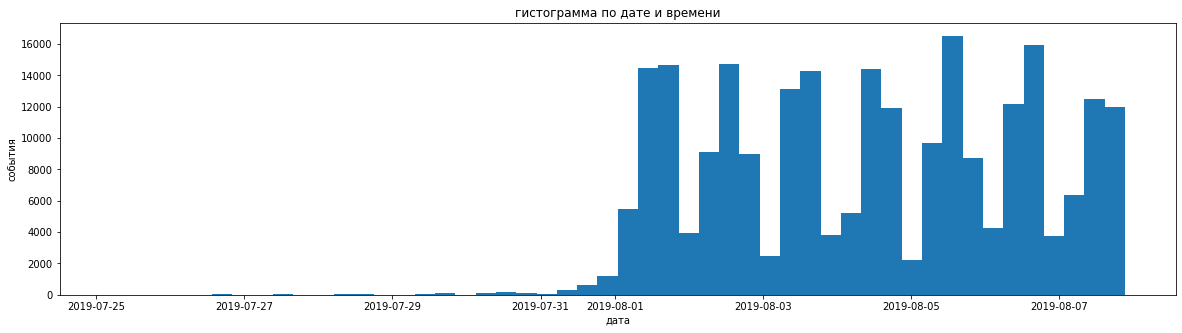

In [ ]:
# Постройте гистограмму по дате и времени.
#df['event_date'].hist(bins = 30, figsize = (20,5), xlabelsize = 12)
plt.figure(figsize = (20,5))
plt.hist(df['event_date'], bins =50)
plt.title('гистограммa по дате и времени')
plt.xlabel('дата')
plt.ylabel('события')

Судя по гистограмме можно определить, что полные данные начинают появляться примерно с 1 августа, предлааю данные до 1 августа отбросить

In [ ]:
drop = df.query('event_date < 20190801')
drop.count()

event         2826
user          2826
dt            2826
group         2826
event_date    2826
month         2826
weekday       2826
date          2826
time          2826
dtype: int64

2826 строк удаляем, это чуть больше 1% данных

In [ ]:
df1 = df.query('event_date >= 20190801')
df.count()

event         243713
user          243713
dt            243713
group         243713
event_date    243713
month         243713
weekday       243713
date          243713
time          243713
dtype: int64

In [ ]:
# посчитаем кол-во потерянных данных

print('Кол-во  потерянных событий :', df['event'].count() - df1['event'].count())
print('% потерянных событий:', (df['event'].count() - df1['event'].count()) / df['event'].count())

print('Кол-во потерянных клиентов :', df['user'].nunique() - df1['user'].nunique())
print('% потерянных клиентов :', (df['user'].nunique() - df1['user'].nunique()) / df['user'].nunique())

Кол-во  потерянных событий : 2826
% потерянных событий: 0.011595606307418972
Кол-во потерянных клиентов : 17
% потерянных клиентов : 0.0022513574361011784


In [ ]:
df = df.query('event_date >= 20190801')
df.count()

event         240887
user          240887
dt            240887
group         240887
event_date    240887
month         240887
weekday       240887
date          240887
time          240887
dtype: int64

In [ ]:
df['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

**Вывод**

- общее количество клиентов - 7 551
- событий - 243 713
- среднее число событий на одного клиента - 32
- по дате принято решенеие об удалении старых данных до 1 авуста 2019 года
- доля отброшенных событий составила чуть больше 1% - отброшено 2 826 событий
- данные (пользователи) есть для всех трёх тестируемых групп

In [ ]:
#Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
df.groupby('event').agg({'user':'count'}).sort_values(by = 'user', ascending = False)

,user
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [ ]:
event = df['user'].nunique()
event

7534

In [ ]:
#Посчитайте, сколько пользователей совершали каждое из этих событий.
#Отсортируйте события по числу пользователей.
count_event = df.groupby('event').agg({'user':'nunique'}).sort_values(by = 'user', ascending = False)
count_event = count_event.query('event != "Tutorial"')
count_event

,user
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539



Можно определить 5 событий:

- MainScreenAppear - появление главного экрана
- OffersScreenAppear - появление страницы каталога
- CartScreenAppear - появление страницы с корзиной
- PaymentScreenSuccessful - появление экрана с успешной оплатой
- Tutorial - руководство к использованию


Логичный исход воронки: открытие главного экрана, далее просмотр каталога, переход в корзину и успешная оплата товара.
Туториал пункт не обязательный, он не вписывается в воронку


In [ ]:
#Посчитайте долю пользователей, которые хоть раз совершали событие.
segment = (count_event/event)*100
segment

,user
event,
MainScreenAppear,98.473586
OffersScreenAppear,60.963632
CartScreenAppear,49.561986
PaymentScreenSuccessful,46.973719


In [ ]:
#Посчитайте, сколько пользователей совершали каждое из этих событий.
#Отсортируйте события по числу пользователей.
count_event = df.groupby('event').agg({'user':'nunique'}).sort_values(by = 'user', ascending = False)
count_event

,user
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [ ]:
#По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
#То есть для последовательности событий A → B → C посчитайте отношение числа пользователей
#с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

i = (df.groupby('event')
     .agg({'user': 'nunique'})
     .sort_values(by='user', ascending=False))

# посчитать количество событий от первого этапа воронки
i['initial'] = i['user'] / i['user']['MainScreenAppear']

# посчитаем количество событий по отношению к предыдущему
i['previous'] = i['user'] / i['user'].shift(1)
i['previous'].fillna(inplace=True, value=1)

i.style.format({'initial': '{:.1%}', 'previous': '{:.1%}'})

,user,initial,previous
event,,,
MainScreenAppear,7419,100.0%,100.0%
OffersScreenAppear,4593,61.9%,61.9%
CartScreenAppear,3734,50.3%,81.3%
PaymentScreenSuccessful,3539,47.7%,94.8%
Tutorial,840,11.3%,23.7%


[Text(0.5, 0, 'Процент'), Text(0, 0.5, 'Событие')]

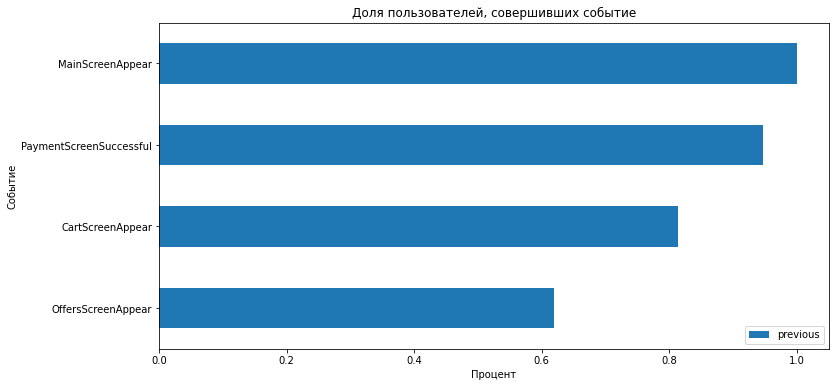

In [ ]:
(
 i
    .query('event != "Tutorial"')
    .pivot_table(index='event', values='previous')
    .sort_values('previous')
    .plot(kind='barh', title='Доля пользователей, совершивших событие', figsize=(12,6))
    .set(xlabel='Процент', ylabel='Событие')
)

In [ ]:
i = i.query('event != "Tutorial"')
i

,event,user,initial,previous
0,MainScreenAppear,7419,1.000000,1.000000
1,OffersScreenAppear,4593,0.619086,0.619086
2,CartScreenAppear,3734,0.503302,0.812976
3,PaymentScreenSuccessful,3539,0.477018,0.947777


In [ ]:
import plotly.express as px
from plotly import graph_objects as go

i = i.reset_index()
fig = go.Figure(go.Funnel(x = i['user'], y = i['event'], textinfo = "value+percent initial+percent previous"))
fig.show();

исходя из данных таблицы и графика мы видим, что наибольшее число пользователей теряются при переходе с главного экрана на каталог.
40% клиентов не доходят до каталога.
47% клиентов доходят до окна с оплатой.

**Вывод**

Изучили события:
MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, скорее всего последовательность выполнения такая. С событием Туториал разобраться не удалось, скорей всего это дополнительная фича для тех кто не разобрался.
Самое часто встречающееся событие - это MainScreenAppear.
С MainScreenAppear 40% пользователей не переходят на следующее событие OffersScreenAppear, это максимальное число не дошедших с одного события на другое.
47% пользователей доходит от первого события до оплаты.

In [ ]:
# Сколько пользователей в каждой экспериментальной группе?
u = df.groupby('group')['user'].nunique()
u

group
246    2484
247    2513
248    2537
Name: user, dtype: int64

In [ ]:
# проверка пересечения групп

df.groupby('user')['group'].nunique().reset_index().query('group > 1').sum()

user     0.0
group    0.0
dtype: float64

In [ ]:
t = df.pivot_table(index = 'event', columns = 'group', values = 'user', aggfunc = 'nunique').sort_values(248, ascending=False)
t

group,246,247,248
event,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


In [ ]:
# посчитаем долю пользователей по событиям

t['r_246'] = round (t[246] / u[246]*100)
t['r_247'] = round (t[247] / u[247]*100)
t['r_248'] = round (t[248] / u[248]*100)
t

group,246,247,248,r_246,r_247,r_248
event,,,,,,
MainScreenAppear,2450,2476,2493,99.0,99.0,98.0
OffersScreenAppear,1542,1520,1531,62.0,60.0,60.0
CartScreenAppear,1266,1238,1230,51.0,49.0,48.0
PaymentScreenSuccessful,1200,1158,1181,48.0,46.0,47.0
Tutorial,278,283,279,11.0,11.0,11.0




H0 - доли сравниваемых групп одинаковы.

H1 - доли сравниваемых групп разные.

In [ ]:
def z_testing(gr_1, gr_2, alpha):

    for i in t.index:

        # пропорция успехов в первой группе:
        p1 = t[gr_1][i] / u[gr_1]

        # пропорция успехов во второй группе:
        p2 = t[gr_2][i] / u[gr_2]

        # пропорция успехов в комбинированном датасете:
        p_combined = ((t[gr_1][i] + t[gr_2][i]) / (u[gr_1] + u[gr_2]))

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / u[gr_1] + 1 / u[gr_2]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = round ((1 - distr.cdf(abs(z_value))) * 2, 3)



        print('Группа {} и группа {}, событие {}, p-значение: {}'.format(gr_1, gr_2, i, p_value))

        if p_value < alpha:
            print("Отвергаем нулевую гипотезу, между долями есть статистически значимая разница")
            print('----------------------------------------------------------------------------')
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
            print('-----------------------------------------------------------------------------')

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247

In [ ]:
z_testing(246, 247, 0.01)

Группа 246 и группа 247, событие MainScreenAppear, p-значение: 0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246 и группа 247, событие OffersScreenAppear, p-значение: 0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246 и группа 247, событие CartScreenAppear, p-значение: 0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246 и группа 247, событие PaymentScreenSuccessful, p-значение: 0.115
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246 и группа 247, событие Tutorial, p-значение: 0.938
Не получилось отвергнуть нулев

С помощью зи теста проверила 2 группы 246/247
Нуевую гипотезу отвергнуть ен удалось, все события в группах не имеют стат значимых различий
за альфу взяла 0,01, для точности резульатта

In [ ]:
z_testing(246, 248, 0.01)

Группа 246 и группа 248, событие MainScreenAppear, p-значение: 0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246 и группа 248, событие OffersScreenAppear, p-значение: 0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246 и группа 248, событие CartScreenAppear, p-значение: 0.078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246 и группа 248, событие PaymentScreenSuccessful, p-значение: 0.212
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246 и группа 248, событие Tutorial, p-значение: 0.826
Не получилось отвергнуть нулев

С помощью зи теста проверила 2 группы 246/248 Нулевую гипотезу отвергнуть не удалось, все события в группах не имеют стат значимых различий за альфу взяла 0,01, для точности резульатта

In [ ]:
z_testing(247, 248, 0.01)

Группа 247 и группа 248, событие MainScreenAppear, p-значение: 0.459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 247 и группа 248, событие OffersScreenAppear, p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 247 и группа 248, событие CartScreenAppear, p-значение: 0.579
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 247 и группа 248, событие PaymentScreenSuccessful, p-значение: 0.737
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 247 и группа 248, событие Tutorial, p-значение: 0.765
Не получилось отвергнуть нулеву

С помощью зи теста проверила 2 группы 247/248 Нулевую гипотезу отвергнуть не удалось, все события в группах не имеют стат значимых различий за альфу взяла 0,01, для точности резульатта

In [ ]:
# посчитаем общее количество клиентов для 246 и 247 групп

u[246_247] = u[246] + u[247]
t[246_247] = t[246] + t[247]
t['r_246_247'] = round (t[246_247] / u[246_247]*100)
t

group,246,247,248,r_246,r_247,r_248,246247,r_246_247
event,,,,,,,,
MainScreenAppear,2450,2476,2493,99.0,99.0,98.0,4926,99.0
OffersScreenAppear,1542,1520,1531,62.0,60.0,60.0,3062,61.0
CartScreenAppear,1266,1238,1230,51.0,49.0,48.0,2504,50.0
PaymentScreenSuccessful,1200,1158,1181,48.0,46.0,47.0,2358,47.0
Tutorial,278,283,279,11.0,11.0,11.0,561,11.0


In [ ]:
z_testing(246247, 248, 0.01)

Группа 246247 и группа 248, событие MainScreenAppear, p-значение: 0.294
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246247 и группа 248, событие OffersScreenAppear, p-значение: 0.434
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246247 и группа 248, событие CartScreenAppear, p-значение: 0.182
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246247 и группа 248, событие PaymentScreenSuccessful, p-значение: 0.6
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Группа 246247 и группа 248, событие Tutorial, p-значение: 0.765
Не получилось отв

Добавила новые столбцы: сумма клиентов в группах 246 и 247 и их доли по событиям.
проверили гипотезу о равенстве долей между 246+247 и 248 группам
Нулевую гипотезу отвергнуть не удалось, все события в группах не имеют стат значимых различий за альфу взяла 0,01, для точности результата

**Вывод**

Количество пользователей по группам:

246 - 2484

247 -  2513

248 -  2537

Посчитала пользователей всех экспериментальных групп по всем событиям.


Самое популярное событие для всех трех групп - это MainScreenAppear


Были сформулированы гипотезы для трех групп и всех событий:

H0 - доли сравниваемых групп одинаковы.


H1 - доли сравниваемых групп разные.


Стат знач различий по всем событиям для А/А теста групп 246 и 247 не выявлено.
Стат знач различий по всем событиям для А/А/В теста не выявлено.
Стат знач различий по всем событиям для А+А/В теста не выявлено.


Исходя из данных теста задумка дизайнеров по смене шрифта не имеет влияния на пользователей в группах.

**ОБЩИЙ ВЫВОД**



общее количество клиентов - 7 551
событий - 243 713
среднее число событий на одного клиента - 32.

По данным в гиторгамме по дате принято решенеие об удалении данных до 1 августа 2019 года.

Для отброшенных событий составила чуть больше 1%.

Все три группы присутствуют в эксперименте.


246  -  2484

247  -  2513

248  -  2537


Есть события:

MainScreenAppear (просмотр главного экрана),

OffersScreenAppear (каталог),

CartScreenAppear (корзина),

PaymentScreenSuccessful (экран оплаты), выполняющиеся пользователями в данной последовательности.

С туториалом определиться не удалось.


Часто используемое событие для всех групп - это MainScreenAppear.


С события MainScreenAppear около 40% пользователей не переходят на OffersScreenAppear, это наибольшее число не дошедших с одного события на другое.

47% пользователей проходит всю воронку событий до оплаты.


Провели А/А тест.

Итог - статистически значимых различий не выявлено.


Сформулировали гипотезы для трех групп и всех событий:

H0 - доли сравниваемых групп одинаковы.

H1 - доли сравниваемых групп разные.


Стат знач различий между А/А/В и А+А/В тестами не выявлено, задумка дизайнеров по смене шрифта не имеет влияния на пользователей в группах.